In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_stock_prices = pd.read_csv("./train_files/stock_prices.csv")

In [3]:
train_stock_prices.drop(['ExpectedDividend'], axis=1, inplace=True)
train_stock_prices.drop(['RowId'], axis=1, inplace=True)
train_stock_prices.drop(['SupervisionFlag'], axis=1, inplace=True)
train_stock_prices.drop(['AdjustmentFactor'], axis=1, inplace=True)

In [4]:
t = train_stock_prices.copy()

In [5]:
t.sort_values(by=['SecuritiesCode','Date'], inplace=True)
t['Open'].interpolate(inplace=True)
t['High'].interpolate(inplace=True)
t['Low'].interpolate(inplace=True)
t['Close'].interpolate(inplace=True)
t.loc[t['Volume'] == 0,"Volume"] = np.nan
t['Volume'].interpolate(inplace=True)
t['Target'].interpolate(inplace=True)

In [6]:
STOCK = t.loc[t['SecuritiesCode'] == 1301].reset_index(drop=True).copy()

In [7]:
STOCK['diffClose'] = STOCK['Close'].diff(periods=1)/STOCK['Close']
STOCK['diffHigh'] = STOCK['High'].diff(periods=1)/STOCK['High']
STOCK['diffHighShift1'] = STOCK['diffHigh'].shift(-1)
STOCK['diffLow'] = STOCK['Low'].diff(periods=1)/STOCK['Low']
STOCK['diffLowShift1'] = STOCK['Low'].diff(periods=1).shift(-1)
STOCK['diffOpen'] = STOCK['Open'].diff(periods=1)/STOCK['Open']
STOCK['diffCloseShift1'] = (STOCK['Close'].diff(periods=1)/STOCK['Close']).shift(-1)
STOCK['pctDailyChange'] = (STOCK['Close'] - STOCK['Open'])/STOCK['Close']
STOCK['diffVolume'] = STOCK['Volume'].diff()/STOCK['Volume']
STOCK = STOCK.dropna()

In [8]:
codes = t.loc[t['Date'] <= STOCK['Date'].iloc[0]]['SecuritiesCode'].unique()
codes

array([1301, 1332, 1333, ..., 9993, 9994, 9997], dtype=int64)

In [9]:
for code in codes:
    t.loc[t['SecuritiesCode'] == code, 'diffClose'] = t.loc[t['SecuritiesCode'] == code]['Close'].diff(periods=1)/t.loc[t['SecuritiesCode'] == code]['Close']
    #break

In [10]:
t_codes = t[t['SecuritiesCode'].isin(codes)].copy()

In [11]:
features = ['diffOpen', 'diffHigh', 'diffLow', 'diffClose', 'diffVolume'] 
target_feature = 'diffClose'

In [12]:
corrs = []
X_test_m, y_test = [], []
X_train_m, y_train = [], []
history_size = 1 # training history
val_size = 100

for i in range(0, len(STOCK) - history_size - val_size):
    date = STOCK.Date.iloc[i]
    tmp = t_codes.loc[t_codes['Date'] == date]['diffClose'].values
    X_train_m.append(tmp)
    y_train.append(STOCK[target_feature].iloc[i+history_size])

for i in range(len(STOCK) - history_size - val_size, len(STOCK) - history_size):
    date = STOCK.Date.iloc[i]
    tmp = t_codes.loc[t_codes['Date'] == date]['diffClose'].values
    X_test_m.append(tmp)
    y_test.append(STOCK[target_feature].iloc[i+history_size])

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [14]:
batchSize=32
dataset_train = Dataset(X_train_m, y_train)
dataset_test = Dataset(X_test_m, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

c:\temp\ipykernel_10440\1305820006.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  self.X = torch.Tensor(X)


In [15]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = Linear(n_inputs, 100)
        self.layer2 = Linear(100, 100)
        self.layer3 = Linear(100, 1)
        self.activation = LeakyReLU()
 
    def forward(self, X):
        X = self.layer1(X)
        X = self.activation(X)
        X = self.layer2(X)
        X = self.activation(X) 
        X = self.layer3(X)
        return X

In [16]:
model_m = MLP(history_size*len(codes)).to(device)

In [17]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model_m.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, min_lr=1e-5, factor=0.5)

In [19]:
start_time = datetime.now()

corrs = []

for epoch in range(1401):
    train_loss = 0
    model_m.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model_m(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model_m.eval()
    
    with torch.no_grad():
        x = torch.Tensor(X_test_m)
        y_pred = model_m(x.to(device))
        y_pred = y_pred.squeeze(1).cpu().detach().numpy()
        corr = abs(np.corrcoef(y_pred, y_test)[0][1])
        corrs.append(corr)
    
    if corr > 0.4:
        print(corr)
        break
        
    #scheduler.step(corr)
    
    if epoch % 100 == 0:
        print(max(corrs))

print(datetime.now() - start_time)

0.04922438722952269
0.16588228310647765
0.2121293397613035
0.38259504608427947
0.3966887835998344
0.3966887835998344
0.40596793447051543
0:00:49.698410


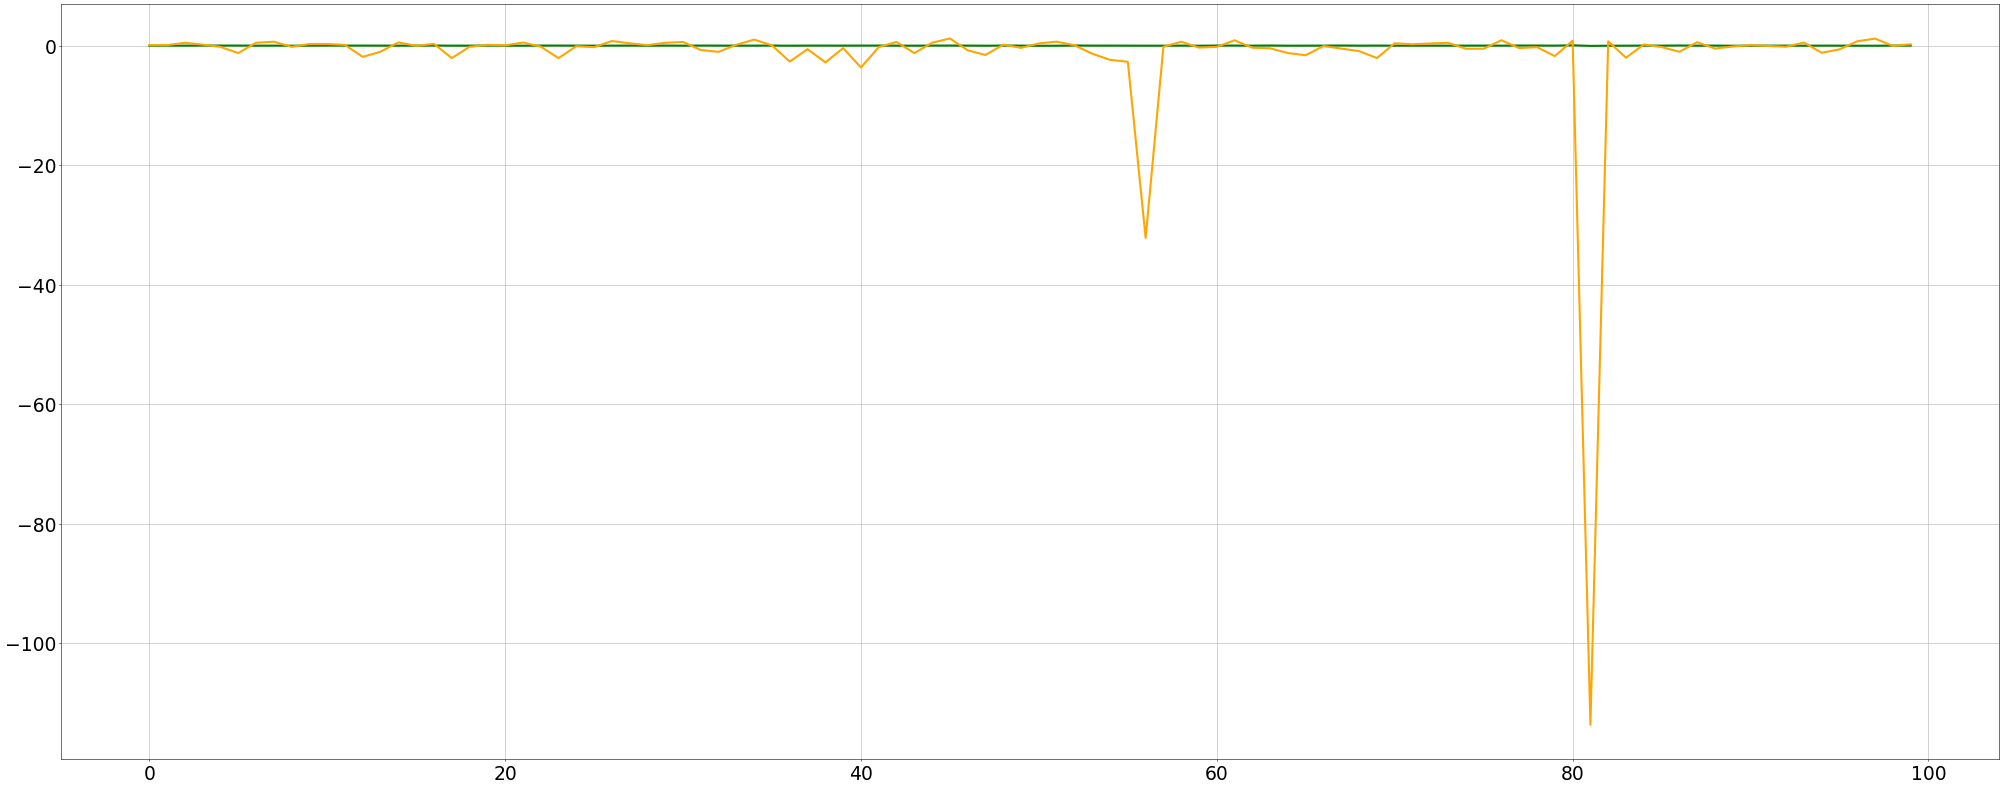

In [20]:
fig1, ax1 = plt.subplots(figsize=(50, 20), dpi=50)
ax1.tick_params(axis='y', which='both', labeltop='on', labelbottom='off', labelsize=27)
ax1.tick_params(axis='x', labelbottom='off', labelsize=27)
ax1.grid()
ax1.plot(y_test, lw=3, color='green')
ax1.plot(y_pred, lw=3, color='orange')

In [22]:
### model_d

In [23]:
corrs = []
X_test_d, y_test = [], []
X_train_d, y_train = [], []
history_size = 4 # training history
val_size = 100

for i in range(0, len(STOCK) - history_size - val_size):
    tmp = []
    for j in range(history_size):
        for f in features:
            tmp.append(STOCK[f].iloc[i+j])
    X_train_d.append(tmp)
    y_train.append(STOCK[target_feature].iloc[i+history_size])

for i in range(len(STOCK) - history_size - val_size, len(STOCK) - history_size):
    tmp = []
    for j in range(history_size):
        for f in features:
            tmp.append(STOCK[f].iloc[i+j])
    X_test_d.append(tmp)
    y_test.append(STOCK[target_feature].iloc[i+history_size])

In [24]:
batchSize=32
dataset_train = Dataset(X_train_d, y_train)
dataset_test = Dataset(X_test_d, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

In [25]:
model_d = MLP(history_size*len(features)).to(device)

In [26]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-1, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, min_lr=1e-5, factor=0.5)

In [27]:
start_time = datetime.now()

corrs = []

for epoch in range(1401):
    train_loss = 0
    model_d.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model_d(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model_d.eval()
    
    with torch.no_grad():
        x = torch.Tensor(X_test_d)
        y_pred = model_d(x.to(device))
        y_pred = y_pred.squeeze(1).cpu().detach().numpy()
        corr = abs(np.corrcoef(y_pred, y_test)[0][1])
        corrs.append(corr)
    
    if corr > 0.58:
        print(corr)
        break
        
    #scheduler.step(corr)
    
    if epoch % 100 == 0:
        print(max(corrs))

print(datetime.now() - start_time)

0.493709132464196
0.493709132464196
0.493709132464196
0.5106113470592814
0.5106113470592814
0.5106113470592814
0.5115826310030303
0.5115826310030303
0.588564638840123
0:00:54.025595


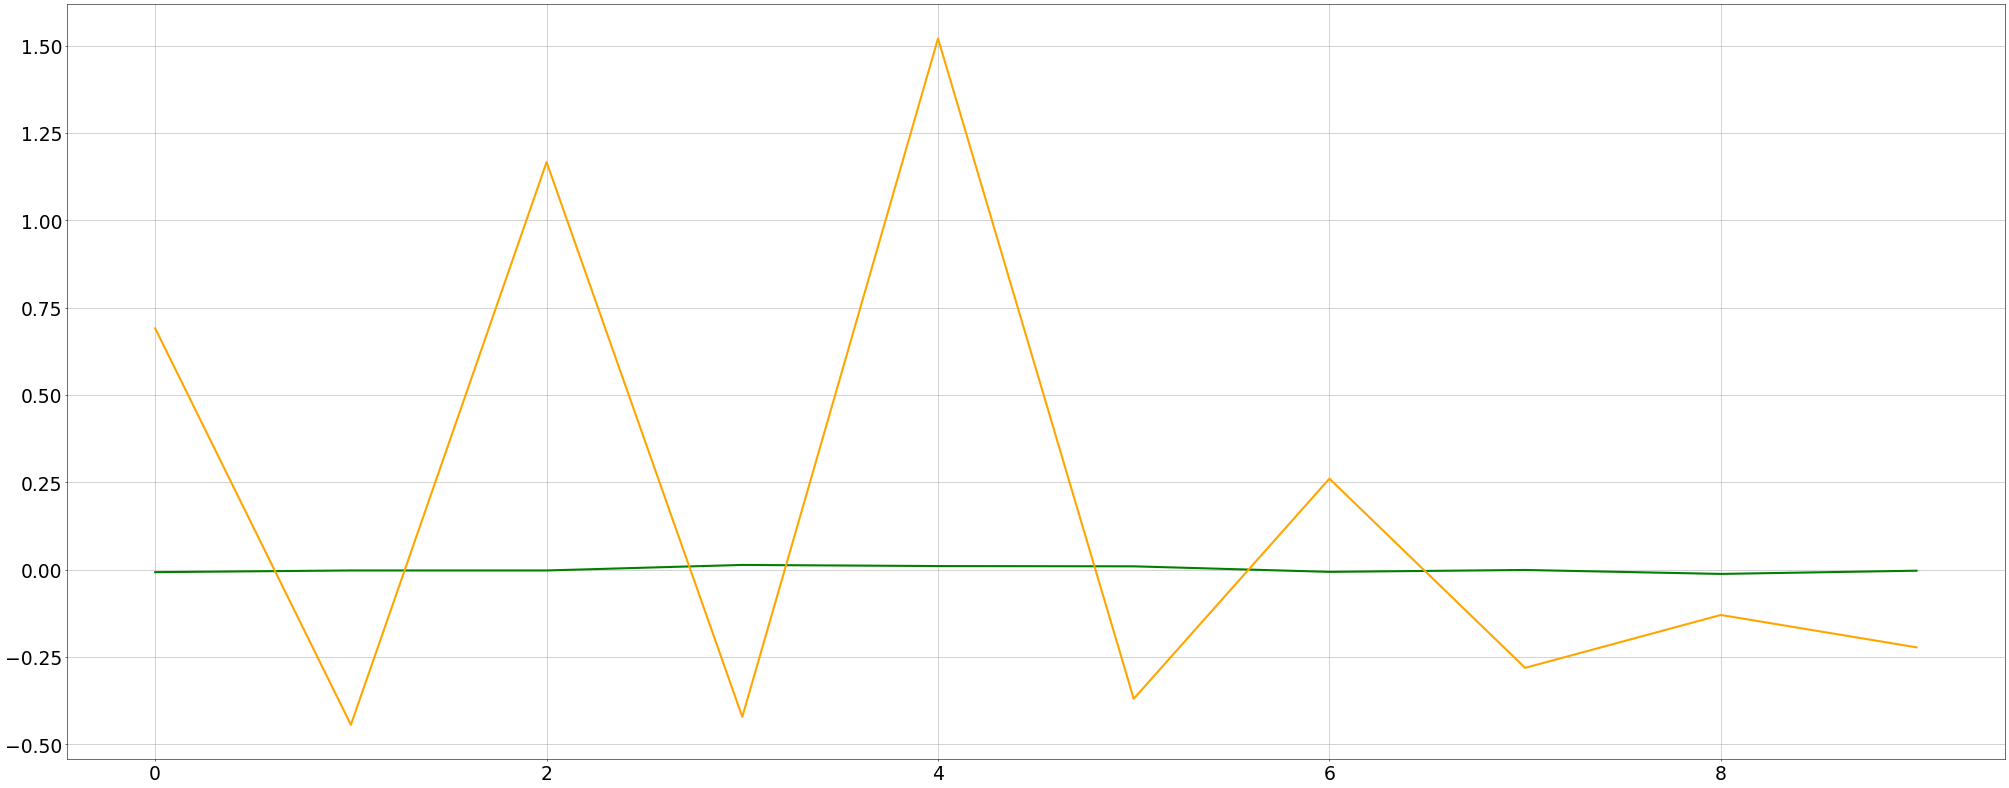

In [28]:
fig1, ax1 = plt.subplots(figsize=(50, 20), dpi=50)
ax1.tick_params(axis='y', which='both', labeltop='on', labelbottom='off', labelsize=27)
ax1.tick_params(axis='x', labelbottom='off', labelsize=27)
ax1.grid()
ax1.plot(y_test[:10], lw=3, color='green')
ax1.plot(-y_pred[:10], lw=3, color='orange')

In [30]:
### Ensamble dataset

In [31]:
m_out_train = model_m(torch.Tensor(X_train_m[3:]).to(device))
d_out_train = model_d(torch.Tensor(X_train_d).to(device))
m_out_test = model_m(torch.Tensor(X_test_m).to(device))
d_out_test = model_d(torch.Tensor(X_test_d).to(device))

In [32]:
history_size = 1
close_past_day_train = []
close_past_day_test = []
ens_y_train = []
ens_y_test = []

for i in range(3, len(STOCK) - history_size - val_size):   
    close_past_day_train.append(STOCK['Close'].iloc[i])
    ens_y_train.append(STOCK['diffClose'].iloc[i+history_size])

for i in range(len(STOCK) - history_size - val_size, len(STOCK) - history_size):
    close_past_day_test.append(STOCK['Close'].iloc[i])
    ens_y_test.append(STOCK['diffClose'].iloc[i+history_size])

In [33]:
ens_X_train = [[m_out_train[i], d_out_train[i]] for i in range(len(d_out_train))]
ens_X_test = [[m_out_test[i], d_out_test[i]] for i in range(len(d_out_test))]

In [34]:
batchSize=32
dataset_train = Dataset(ens_X_train, ens_y_train)
dataset_test = Dataset(ens_X_test, ens_y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

In [39]:
class MLP1(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP1, self).__init__()
        self.layer1 = Linear(n_inputs, 10)
        self.layer2 = Linear(10, 10)
        self.layer3 = Linear(10, 1)
        self.activation = LeakyReLU()
 
    def forward(self, X):
        X = self.layer1(X)
        X = self.activation(X) 
        X = self.layer2(X)
        X = self.activation(X) 
        X = self.layer3(X)
        return X

In [40]:
model_e = MLP1(len(ens_X_train[0])).to(device)

In [52]:
np.absolute(np.array(y_test)).mean()

0.008220617242149415

In [53]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, min_lr=1e-5, factor=0.5)

In [54]:
start_time = datetime.now()

corrs = []

for epoch in range(1401):
    train_loss = 0
    model_e.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model_e(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model_e.eval()
    
    with torch.no_grad():
        eval_loss = 0
        for i, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            yhat = model_e(inputs)
            loss = criterion(yhat, targets)
            eval_loss += loss
        
    #scheduler.step(corr)
    
    if epoch % 100 == 0:
        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0104, device='cuda:0')
Epoch: 100, train loss: tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0091, device='cuda:0')
Epoch: 200, train loss: tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0092, device='cuda:0')
Epoch: 300, train loss: tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0086, device='cuda:0')
Epoch: 400, train loss: tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0094, device='cuda:0')
Epoch: 500, train loss: tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0090, device='cuda:0')
Epoch: 600, train loss: tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0091, device='cuda:0')
Epoch: 700, train loss: tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0090, device='cuda:0')
Epoch: 800

In [ ]:
with torch.no_grad():
    x = torch.Tensor(ens_X_test)
    y_pred = model_e(x.to(device))
    y_pred = y_pred.squeeze(1).cpu().detach().numpy()
    corr = abs(np.corrcoef(y_pred, ens_y_test)[0][1])

In [ ]:
fig1, ax1 = plt.subplots(figsize=(50, 20), dpi=50)
ax1.tick_params(axis='y', which='both', labeltop='on', labelbottom='off', labelsize=27)
ax1.tick_params(axis='x', labelbottom='off', labelsize=27)
ax1.grid()
ax1.plot(ens_y_test, lw=3, color='green')
ax1.plot(y_pred, lw=3, color='orange')

In [ ]:
with torch.no_grad():
    x = torch.Tensor(ens_X_test[19])
    print(x)
    y_pred = model_e(x.to(device))
    print(y_pred)
    print(ens_y_test[19])